# Sparkify Data Analysis
Table of Contents 
1. Project Motivation
2. Required Packages
3. Load and Clean data [ ETL ] 
4. Feature Engineering 
5. Modelling
7. Final Model and Conclusion

#### Project Motivation [ "Udacity Capstone Project" ]
>The dataset used in current analysis includes user basic details and each user interaction with the Sparkify service. Our goal is to build a model with optimal accuracy and low false positives, to identify costumers, who are likely to leave the service, so any additional promotions can be sent to avoid costumer churning.

>The current data analysis was performed using Spark, any cloud or cluster can be used to perform the analysis instead of spark.

> Churn Definition: 
when customers or subscribers stop doing business with a company or service. … Customer churn impedes growth, so companies should have a defined method for calculating customer churn in a given period of time.

> How Churn is defined for current Data:
Column “churn” is created based on “Cancellation Confirmation “event, user with ““Cancellation Confirmation “ were labelled “1” otherwise “0”

#### Data Overview 
> In current analysis, we will be using user behavior log data.
> outline of data : 
    - data includes basic  information about each user and thier interaction with Sparkify.
    - each user can have multiple entries.
    - data also include information on churned users i.e. users who unsubscribed/ cancelled the Sparkify subscription.
    


#### Required Packages 
    - Pyspark 
    - Spark [ can use AWS or IBM cloud ] 
    - Matplotlib
    - Seaborn
    - pandas
    


In [3]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes,LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import Window

import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from time import time

In [4]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# full sparkify dataset "s3n://dsnd-sparkify/sparkify_event_data.json"
#load dataset 
df       = spark.read.json('mini_sparkify_event_data.json')
df_spark = df

    Data Cleaninig Steps 
         > Rows with empty userIds and session Ids are filtered out
         > duplicate "UserIDs" and "page" information are dropped out 

In [6]:
#check data 
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [7]:
df.count()

286500

In [8]:
#Drop records with missing  or empty , userIds and session Ids.
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
print ("data after removing NAs : %d"%( df.count() ))
df = df.filter(df.userId!="")
print ("data after removing empty userIds : %d"%( df.count() ))

data after removing NAs : 286500
data after removing empty userIds : 278154


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
# define churn 
churn_events = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df           = df.withColumn('churn_event', churn_events('page'))
# label user who churned
df  = df.withColumn('churn', max('churn_event').over( Window.partitionBy('userId') ) )

In [10]:
df.select(['userId', 'churn']).dropDuplicates().show(20)


+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



In [11]:
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



#### Data Exploration 

A. Relation  between users and songs listend on Sparkify 

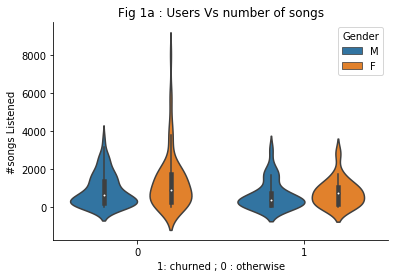

In [12]:
# User  distribution over churn and non-churn users
df_subset     = df.where('page == "NextSong" OR page == "Thumbs Up"').groupby(['userId', 'churn', 'gender', 'page'])
df_subset_pd  = df_subset.count().toPandas()
plot_data     = df_subset_pd.pivot_table(index=['userId','churn','gender'], values='count', columns='page').reset_index()

#Plotting 
ax = sns.violinplot(data=plot_data, x='churn', y='NextSong', hue='gender')
plt.xlabel('1: churned ; 0 : otherwise')
plt.ylabel('#songs Listened')
plt.legend(title='Gender', loc='best')
plt.title('Fig 1a : Users Vs number of songs')
sns.despine(ax=ax);

                      From the Plot above, 
                               females listen to higer number of songs than males.

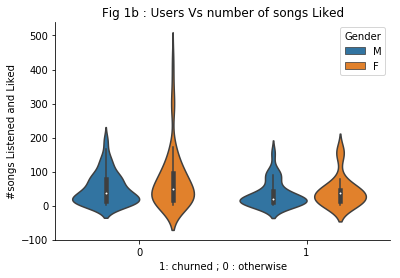

In [13]:

ax = sns.violinplot(data=plot_data, x='churn', y='Thumbs Up', hue='gender')
plt.xlabel('1: churned ; 0 : otherwise')
plt.ylabel('#songs Listened and Liked')
plt.legend(title='Gender', loc='best')
plt.title('Fig 1b : Users Vs number of songs Liked')
sns.despine(ax=ax);

        From above plot, 
            no much notable varaiation maong four distributions

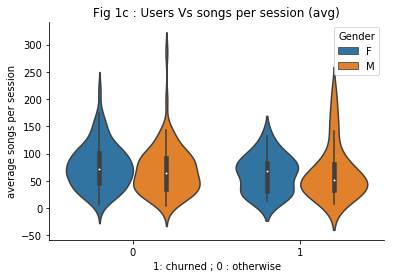

In [14]:
df_subset     = df.where('page == "NextSong"').groupby(['userId', 'churn', 'gender','sessionId', 'page'])
df_subset     = df_subset.count().groupby(['churn', 'userId', 'gender']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'avg_songs_played')
df_subset_pd  =  df_subset.toPandas()
ax = sns.violinplot('churn', y='avg_songs_played', hue='gender', data=df_subset_pd)
plt.xlabel('1: churned ; 0 : otherwise')
plt.ylabel('average songs per session')
plt.legend(title='Gender', loc='best')
plt.title('Fig 1c : Users Vs songs per session (avg)')
sns.despine(ax=ax);

From above plot, 
         - Among Non-Churned users, both male and female had listened to same number of songs per session
         - while, among churned users, males listened to slightly more songs per session than females.

B. Which users are un-subscribing or cancelling the plan , paid or free users

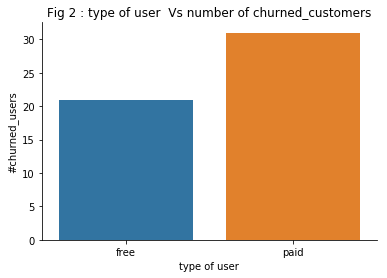

In [15]:
df_subset  = df.filter('page == "Cancellation Confirmation"').groupby('level').count()
plot_data  = df_subset.toPandas()

ax = sns.barplot(data=plot_data, x='level', y='count')
plt.xlabel('type of user')
plt.ylabel('#churned_users')
plt.title('Fig 2 : type of user  Vs number of churned_customers')
sns.despine(ax=ax);

Which users are un-subscribing or cancelling the plan , paid or free users : from plot, "Paid Users"

C. Relation between  users and registration period

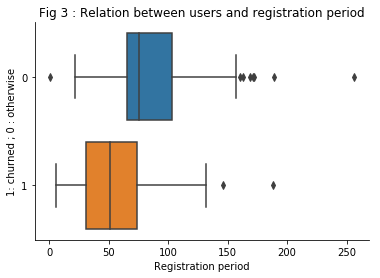

In [16]:
# add a time column to df
time       = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_valid   = df.withColumn('event_time', time('ts'))
df_valid   = df.withColumn('registration_time', time('registration'))
###
df_subset    = df.select('userId','registration','ts','churn').withColumn('lifetime',(df.ts-df.registration))
df_subset    = df_subset.groupBy('userId','churn').agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lifetime')
plot_data_pd = df_subset .select('userId', 'churn', (col('lifetime')/1000/3600/24).alias('lifetime')).toPandas()
#Plotting 
ax = sns.boxplot(data=plot_data_pd, x='lifetime', y='churn', orient='h')
plt.ylabel('1: churned ; 0 : otherwise')
plt.xlabel('Registration period')
plt.title('Fig 3 : Relation between users and registration period')
sns.despine(ax=ax);

From the plot, as expected churned users  were registered for short time period to Sparkify.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Featur 1 : Time since registration

In [17]:
f1 = df_valid \
    .select('userId','registration','ts') \
    .withColumn('lifetime',(df_valid.ts-df_valid.registration)) \
    .groupBy('userId') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', (col('lifetime')/1000/3600/24).alias('lifetime'))
f1.describe().show()

+-------+------------------+-------------------+
|summary|            userId|           lifetime|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|   79.8456834876543|
| stddev|105396.47791907164|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



Feature 2 : Total number of Songs Listened

In [18]:
f2 = df\
    .select('userID','song') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'total_songs')
f2.describe().show()

+-------+------------------+-----------------+
|summary|            userID|      total_songs|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|          1236.24|
| stddev|105396.47791907164|1329.531716432519|
|    min|                10|                6|
|    max|                99|             9632|
+-------+------------------+-----------------+



Feature 3 : Number of songs liked i.e. thumb's up 

In [19]:
f3 = df_valid \
    .select('userID','page') \
    .where(df_valid.page == 'Thumbs Up') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_up') 
f3.describe().show()

+-------+------------------+-----------------+
|summary|            userID|     num_thumb_up|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121881|65.67028650524044|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+



Feature 4 : Number of songs liked i.e. thumb's down

In [20]:
f4 = df_valid \
    .select('userID','page') \
    .where(df_valid.page == 'Thumbs Down') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_down')
f4.describe().show()

+-------+------------------+------------------+
|summary|            userID|    num_thumb_down|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893777|13.198108566983787|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



Feature 5 : Songs listened per session

In [21]:
f5 = df_valid.where('page == "NextSong"') \
    .groupby(['userId', 'sessionId']) \
    .count() \
    .groupby(['userId']) \
    .agg({'count':'avg'}) \
    .withColumnRenamed('avg(count)', 'avg_songs_played')
f5.describe().show()

+-------+------------------+-----------------+
|summary|            userId| avg_songs_played|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|70.78971233958933|
| stddev|105396.47791907164| 42.6153697543817|
|    min|                10|              3.0|
|    max|                99|286.6666666666667|
+-------+------------------+-----------------+



Feature 6 : Gender

In [22]:
f6 = df_valid \
    .select("userId", "gender") \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int'))
f6.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             gender|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.4622222222222222|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



Feature 7 : duration of time for which songs were listened

In [23]:
f7 = df_valid \
    .select('userID','length') \
    .groupBy('userID') \
    .sum() \
    .withColumnRenamed('sum(length)', 'listen_time')
f7.describe().show()

+-------+------------------+------------------+
|summary|            userID|       listen_time|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155543|
| stddev|105396.47791907164| 275396.4038847635|
|    min|                10|         691.66884|
|    max|                99|1991154.9155799907|
+-------+------------------+------------------+



Response Variable

In [24]:
#Y label i.e. Churn 
label = df_valid \
    .select('userId', col('churn').alias('label')) \
    .dropDuplicates()
label.describe().show()

+-------+------------------+------------------+
|summary|            userId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [25]:
#Merge Labels
data_for_model  = f1.join(f2,'userID','outer') \
    .join(f3,'userID','outer') \
    .join(f4,'userID','outer') \
    .join(f5,'userID','outer') \
    .join(f6,'userID','outer') \
    .join(f7,'userID','outer') \
    .join(label,'userID','outer') \
    .drop('userID') \
    .fillna(0)

data_for_model.show(5)

+------------------+-----------+------------+--------------+------------------+------+------------------+-----+
|          lifetime|total_songs|num_thumb_up|num_thumb_down|  avg_songs_played|gender|       listen_time|label|
+------------------+-----------+------------+--------------+------------------+------+------------------+-----+
|  55.6436574074074|        381|          17|             5|39.285714285714285|     1| 66940.89735000003|    0|
| 70.07462962962963|        474|          21|             6|              64.5|     0| 94008.87593999993|    0|
| 71.31688657407408|         11|           0|             0|               8.0|     0|2089.1131000000005|    1|
|131.55591435185184|       4825|         171|            41|145.67857142857142|     1|1012312.0927899999|    0|
|19.455844907407407|       2464|         100|            21|             211.1|     0| 523275.8428000004|    1|
+------------------+-----------+------------+--------------+------------------+------+------------------

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [26]:
#Vector assembly  
cols      = ["lifetime", "total_songs", "num_thumb_up",'num_thumb_down','avg_songs_played', 'gender', 'listen_time']
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data      = assembler.transform( data_for_model )
# standard scaler
# to standardize features, mean is calculated for each feature and divided by standard deviation of each feature.
scaler            = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel       = scaler.fit(data)
data              = scalerModel.transform(data)
# train test split
train, rest = data.randomSplit([0.6, 0.4], seed=42)
validation, test = rest.randomSplit([0.5, 0.5], seed=42)

In [30]:
train_Pd = train.toPandas()

In [36]:
train_Pd.shape

(142, 10)

In [38]:
train_Pd.groupby('label').count()

,lifetime,total_songs,num_thumb_up,num_thumb_down,avg_songs_played,gender,listen_time,NumFeatures,features
label,,,,,,,,,
0,110,110,110,110,110,110,110,110,110
1,32,32,32,32,32,32,32,32,32


In [37]:
print("Number of Churn labels i..e. 1 : 32")
print("Number of otherwise labels i..e. 0 : 110")

Number of Churn labels i..e. 1 : 32
Number of otherwise labels i..e. 0 : 110


> The number of churn and otherwise labels were not equal.

> Unbalanced data,can effect model accuracy and performance.


In [70]:
#Function which will be repeatedly used in modelling
#build_model
def build_model(model,train,validation,test): 
    start_time = time()
    #cross validation 
    cv           =  CrossValidator(estimator=model,
                              evaluator=MulticlassClassificationEvaluator(metricName='f1'), 
                              estimatorParamMaps=ParamGridBuilder().build(),
                              numFolds=5)
    #model fitting
    cv_fit       = cv.fit(train)
    #############################################################################################
    #predictions on test Data
    predictions  = cv_fit.transform(test)
    #Eavlauating models  
    evaluator    = MulticlassClassificationEvaluator(predictionCol="prediction")
    print ("Evaluation on test Dataset")
    print('Accuracy: {}'.format(evaluator.evaluate(predictions , {evaluator.metricName: "accuracy"})))
    print('F-1 Score:{}'.format(evaluator.evaluate(predictions , {evaluator.metricName: "f1"})))
    ###############################################################################################
    #predictions on Validation Data
    predictions  = cv_fit.transform(validation)
    #Eavlauating models  
    evaluator    = MulticlassClassificationEvaluator(predictionCol="prediction")
    print ("Evaluation on Validation Dataset")
    print('Accuracy: {}'.format(evaluator.evaluate(predictions , {evaluator.metricName: "accuracy"})))
    print('F-1 Score:{}'.format(evaluator.evaluate(predictions , {evaluator.metricName: "f1"})))
    end_time = time()
    print ("Time took for building the model :  %.2f"%(end_time - start_time))
####

### Model 0. Baseline model
        a. all users labelled as "churn =0"
        b. all users labelled as "churn =1"

In [71]:
#Predictions 
predictions  = test.withColumn('prediction', lit(0.0))
#Eavlauating models  
evaluator    = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(predictions , {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(predictions , {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.7352941176470589
F-1 Score:0.6231306081754736


In [72]:
#Predictions 
predictions  = test.withColumn('prediction', lit(1.0))
#Eavlauating models  
evaluator    = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(predictions , {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(predictions , {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.2647058823529412
F-1 Score:0.11080711354309165


Baseline model has the poor prdictions, let us various other models and pick the one that predicts the best.

### Model 1. Logistic Regression

In [73]:
build_model(LogisticRegression(maxIter=5),train,validation,test)

Evaluation on test Dataset
Accuracy: 0.75
F-1 Score:0.6563202878992354
Evaluation on Validation Dataset
Accuracy: 0.8666666666666667
F-1 Score:0.8047619047619048
Time took for building the model :  694.45


###    "Model : Logistic Regression"
    Evaluation on test Dataset
       Accuracy : 75%
       F-1 Score: 66%
    Evaluation on Validation Dataset
       Accuracy : 87%
       F-1 Score: 80%
    Time took for building the model : 23 mins.

### Model 2 : Gradient Boosted Trees 

In [74]:
build_model(GBTClassifier(maxIter=10,seed=42),train,validation,test)

Evaluation on test Dataset
Accuracy: 0.7205882352941176
F-1 Score:0.7270140411438168
Evaluation on Validation Dataset
Accuracy: 0.8666666666666667
F-1 Score:0.8047619047619048
Time took for building the model :  1840.04


###   "Model : Gradient Boosted Trees"
    Evaluation on test Dataset
       Accuracy : 72%
       F-1 Score: 72%
    Evaluation on Validation Dataset
       Accuracy : 87%
       F-1 Score: 80%
    Time took for building the model : 30 mins.

### Model 3 : Support Vector Machine

In [76]:
build_model(LinearSVC(maxIter=10),train,validation,test)

Evaluation on test Dataset
Accuracy: 0.7352941176470589
F-1 Score:0.6231306081754736
Evaluation on Validation Dataset
Accuracy: 0.8666666666666667
F-1 Score:0.8047619047619048
Time took for building the model :  1073.79


###    "Model : Support Vector Machine"
    Evaluation on test Dataset
       Accuracy : 73%
       F-1 Score: 62%
    Evaluation on Validation Dataset
       Accuracy : 86%
       F-1 Score: 80%
    Time took for building the model : 17mins.

### Final Model and Conclusion 

#### Final Model 
    "Gradient Boosted Trees" has better perfromance than Logistic Regression and Support Vector Machine models.
    Evaluation Stats  on test Dataset : 
    Accuracy: 72%
    F-1 Score:73%
    Evaluation Stats  on Validation Dataset : 
    Accuracy: 87%
    F-1 Score:80%
    Time took for building the model : 32 mins.

#### Conclusion : 
Logistic Regression model, take lowest computational time but compartively, Gradient Boost Trees model have best  prediction accuracy and F1-score value on test and validation datasets.Hence, Gradient Boost Trees model is the final optimal model for identifying  coustmer churn.
It should be noted that only small subset of data is used for modelling, predictions could be improved by using more relevant features and larger data.

Model predictions can  be further improved by, 
 1. Hyper parameter tuning. 
 2. Using training dataset with balanced labels.
 3. Trying other robust algorithms by referring to literature.
            

#### Learning Outcome : 
By performing current data analysis, I could make use of the Datascience skills that I have learn throgh the course work and got and oppurtunity to practically work on Apache Spark.

Blog Post : https://medium.com/@c.yesesri1/sparkify-costumer-data-analysis-b51ac37b4091?sk=8de8044a6da07ca75866dc4027015f8a